# Custom Evaluation

In this notebook, we will evluate the LatteReview package by applying a TitleAbstractReview workflow to a dataset collected for this [systematic review](https://pubmed.ncbi.nlm.nih.gov/36292201/).

## Setting up the notebook

High-level configs

In [1]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv

# Load environment variables from .env file. Adjust the path to the .env file as needed.
load_dotenv(dotenv_path='../.env')

# Enable asyncio in Jupyter
import asyncio
import nest_asyncio

nest_asyncio.apply()

#  Add the package to the path (required if you are running this notebook from the examples folder)
import sys
sys.path.append('../../')


Import required packages

In [3]:
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import numpy as np
import pandas as pd 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import time

from lattereview.providers import LiteLLMProvider
from lattereview.agents import TitleAbstractReviewer
from lattereview.workflows import ReviewWorkflow

## Data

Let's first load the data and see the values its different columns have.

In [20]:
data = pd.read_csv('custom_data/custom_data.csv')
data

,title,abstract,DOI,study_type,clinical_application,organ,modality,cardiovascular,task,deep_learning,external_validation
0,(18)F-FDG PET/CT Uptake Classification in Lymp...,Background Fluorine 18 ((18)F)-fluorodeoxygluc...,10.1148/radiol.2019191114,cross-sectional,diagnosis,lung,pet,0,classification,1,0
1,(18)F-FDG-PET/CT Whole-Body Imaging Lung Tumor...,Under the background of (18)F-FDG-PET/CT multi...,10.1155/2021/8865237,cross-sectional,diagnosis,lung,pet,0,classification,1,0
2,3-D Convolutional Neural Networks for Automati...,Deep two-dimensional (2-D) convolutional neura...,10.1109/jbhi.2018.2879449,cross-sectional,diagnosis,lung,ct,0,detection,1,0
3,3D CNN with Visual Insights for Early Detectio...,The 3D convolutional neural network is able to...,10.1155/2021/6695518,cross-sectional,diagnosis,lung,ct,0,classification,1,0
4,3D deep learning based classification of pulmo...,Classifying ground-glass lung nodules (GGNs) i...,10.1016/j.compmedimag.2020.101814,cross-sectional,diagnosis,lung,ct,0,"segmentation, classification",1,0
...,...,...,...,...,...,...,...,...,...,...,...
973,Vulture-Based AdaBoost-Feedforward Neural Fram...,"In today's scenario, many scientists and medic...",10.1007/s12539-022-00505-3,cross-sectional,diagnosis,lung,xr,0,"segmentation, classification",1,0
974,Wavelet decomposition facilitates training on ...,The adoption of low-dose computed tomography (...,10.1007/s00418-020-01961-y,cross-sectional,diagnosis,lung,ct,0,classification,1,0
975,Weakly unsupervised conditional generative adv...,Because of the rapid spread and wide range of ...,10.1016/j.media.2021.102159,cross-sectional,diagnosis,lung,ct,0,classification,1,0
976,Weakly-supervised lesion analysis with a CNN-b...,Objective.Lesions of COVID-19 can be clearly v...,10.1088/1361-6560/ac4316,cross-sectional,diagnosis,lung,ct,0,classification,1,0


In [5]:
for column in data.columns:
    if column in ["study_type", "clinical_application", "organ", "modality", "cardiovascular", "task", "deep_learning", "external_validation"]:
        print(data[column].value_counts())
        print("-"*50)

study_type
cross-sectional         849
retrospective cohort    101
case control             17
prospective cohort        9
RCT                       2
Name: count, dtype: int64
--------------------------------------------------
clinical_application
diagnosis    823
prognosis    117
treatment     38
Name: count, dtype: int64
--------------------------------------------------
organ
lung           944
heart           20
lymph nodes      5
thorax           4
vessels          3
thymus           2
Name: count, dtype: int64
--------------------------------------------------
modality
ct     697
xr     217
pet     42
mri     12
us      10
Name: count, dtype: int64
--------------------------------------------------
cardiovascular
0    958
1     20
Name: count, dtype: int64
--------------------------------------------------
task
classification                              688
segmentation                                125
segmentation, classification                 62
detection                 

## Inclusion and Exlcusion Criteria

We will then put together three different pairs of inclusion and exclusion criteria that gradually get more complicated and detailed.

In [22]:
search_criteria_1 = {
    "name": "search1",
    "inclusion_criteria": {
        1: "The study must involve CT scans. If multiple modalities are involved, CT scans should be among them.",
    },
    "exclusion_criteria": {
        1: "The study must not include PET scans as one of its modalities.",
    }
}

data["search1"] = data["modality"].isin(["ct", "xr, ct"]).astype(int)
data["search1"].value_counts()

search1
1    697
0    281
Name: count, dtype: int64

In [23]:
search_criteria_2 = {
    "name": "search2",
    "inclusion_criteria": {
        1: "The study must involve CT scans. If multiple modalities are involved, CT scans should be among them.",
        2: "The study should introduce, develop, or discuss a deep learning-baseed classifier.",
    },
    "exclusion_criteria": {
        1: "The study must not include PET scans as one of its modalities.",
        2: "Studies focusing on cardiovascular organs or lung vasculature must be excluded.",
    }
}


data["search2"] = ((data["search1"] == 1) & (data["deep_learning"] == 1) & (data["task"].str.contains("classification")) & (data["cardiovascular"]==0)).astype(int)
data["search2"].value_counts()

search2
0    611
1    367
Name: count, dtype: int64

In [24]:
search_criteria_3 = {
    "name": "search3",
    "inclusion_criteria": {
        1: "The study must involve CT scans. If multiple modalities are involved, CT scans should be among them.",
        2: "The study should introduce, develop, or discuss a deep learning-baseed classifier.",
        3: "The clinical application or model in the study must focus on diagnosis.",
    },
    "exclusion_criteria": {
        1: "The study must not include PET scans as one of its modalities.",
        2: "Studies focusing on cardiovascular organs or lung vasculature must be excluded.",
        3: "All studies that did not have an external test set in addition to their internal test set must be excluded."
    }
}


data["search3"] = ((data["search2"] == 1) & (data["clinical_application"]=="diagnosis") & (data["external_validation"]==1)).astype(int)
data["search3"].value_counts()

search3
0    923
1     55
Name: count, dtype: int64

## Review

Now let's define two imaginary junior (cheap model) and one senior (expensive model) reviewer agents that all belong to the TitleAbstractReviewer class.

In [9]:
def create_reviewers(inclusion_criteria, exclusion_criteria):

    inclusion_criteria = str(inclusion_criteria)
    exclusion_criteria = str(exclusion_criteria)

    Agent1 = TitleAbstractReviewer(
        provider=LiteLLMProvider(model="gemini/gemini-1.5-flash"),
        name="Agent1",
        backstory="a PhD researcher in biology and computer science",
        inclusion_criteria = inclusion_criteria,
        exclusion_criteria = exclusion_criteria,        
        max_concurrent_requests=30, 
        model_args={"max_tokens": 200, "temperature": 0.1},
    )

    Agent2 = TitleAbstractReviewer(
        provider=LiteLLMProvider(model="gpt-4o-mini"),
        name="Agent2",
        backstory="a PhD researcher in biology and computer science",
        inclusion_criteria = inclusion_criteria,
        exclusion_criteria = exclusion_criteria,        
        max_concurrent_requests=30, 
        model_args={"max_tokens": 200, "temperature": 0.1},
    )

    Agent3 = TitleAbstractReviewer(
        provider=LiteLLMProvider(model="gpt-4o"),
        name="Agent3",
        backstory="a senior MD-PhD researcher with years of experience in conducting systematic reviews in radiology and deep learning",
        inclusion_criteria = inclusion_criteria,
        exclusion_criteria = exclusion_criteria,        
        max_concurrent_requests=30, 
        model_args={"max_tokens": 200, "temperature": 0.1},
        additional_context="""
        Two PhD reviewers have already reviwed this article and disagree on how to evaluate it. You can read their evaluation above.
        """
    )

    return Agent1, Agent2, Agent3

And we will create a workflow with these agents and apply it to our data for three times, each time with a different pair of inclusion and exclusion criteria.

In [10]:
def split_dataframe(df, chunk_size):
    """Splits a DataFrame into smaller DataFrames of a specified chunk size."""
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

async def process_sub_df(sub_df, inclusion_criteria, exclusion_criteria):
    """Processes a single sub DataFrame."""
    Agent1, Agent2, Agent3 = create_reviewers(inclusion_criteria, exclusion_criteria)

    def filter_func(row):
        score1 = int(row["round-A_Agent1_output"]["evaluation"])
        score2 = int(row["round-A_Agent2_output"]["evaluation"])
        if score1 != score2:
            if score1 >= 4 and score2 >= 4:
                return False
            if score1 >= 3 or score2 >= 3:
                return True
        elif score1 == score2 == 3:
            return True
        return False

    title_abs_review = ReviewWorkflow(
        workflow_schema=[
            {
                "round": 'A',
                "reviewers": [Agent1, Agent2],
                "text_inputs": ["title", "abstract"]
            },
            {
                "round": 'B',
                "reviewers": [Agent3],
                "text_inputs": ["title", "abstract", "round-A_Agent1_output", "round-A_Agent2_output"],
                "filter": filter_func
            }
        ]
    )

    updated_df = await title_abs_review(sub_df)
    costs = title_abs_review.get_total_cost()
    return updated_df, costs

async def review(search_criteria, sample_size=None):
    inclusion_criteria = search_criteria["inclusion_criteria"]
    exclusion_criteria = search_criteria["exclusion_criteria"]
    df = data.copy()

    if sample_size:
        df = df.sample(sample_size)

    # Split the DataFrame into sub-DataFrames of size 1000 or less
    sub_dfs = split_dataframe(df, 1000)

    results = []
    total_cost = 0

    for n, sub_df in enumerate(sub_dfs):
        updated_sub_df, sub_cost = await process_sub_df(sub_df, inclusion_criteria, exclusion_criteria)
        results.append(updated_sub_df)
        total_cost += sub_cost
        if n < len(sub_dfs) - 1:
            print(f"\n====== Finished reviewing ({(n + 1) * 1000}/{len(df)}) ======\n")
            print(f"\nTotal cost: {total_cost}")
            print("-" * 50)
            time.sleep(60)  # Wait for 1 minute between processing each sub-DataFrame

    # Concatenate all the updated sub-DataFrames into a unified DataFrame
    unified_df = pd.concat(results)

    # Save the results
    unified_df.to_csv(f"custom_data/{search_criteria['name']}_reviewed.csv")

    # Print the costs
    print(f"\n====== Finished reviewing {search_criteria['name']} ======\n")
    print(f"\nTotal cost: {total_cost}")
    print("-" * 100)

    return unified_df, total_cost

In [50]:
# Run for search1
search1_df, search1_cost = asyncio.run(review(search_criteria_1))


====== Starting review round A (1/2) ======

Processing 978 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 18:59:26: 100%|██████████| 978/978 [00:18<00:00, 53.26it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 18:59:44: 100%|██████████| 978/978 [00:33<00:00, 28.93it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 40 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 19:00:18: 100%|██████████| 40/40 [00:10<00:00,  3.78it/s]

The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing search1 ======


Total cost: 0.0032003500000000002
----------------------------------------------------------------------------------------------------


In [42]:
# Run for search2
search2_df, search2_cost = asyncio.run(review(search_criteria_2))


====== Starting review round A (1/2) ======

Processing 978 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 18:57:44: 100%|██████████| 978/978 [00:19<00:00, 50.54it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 18:58:03: 100%|██████████| 978/978 [00:34<00:00, 28.73it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 84 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 18:58:37: 100%|██████████| 84/84 [00:06<00:00, 12.17it/s]

The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing search2 ======


Total cost: 0.00300465
----------------------------------------------------------------------------------------------------


In [38]:
# Run for search3
search3_df, search3_cost = asyncio.run(review(search_criteria_3))


====== Starting review round A (1/2) ======

Processing 978 eligible rows


['round: A', 'reviewer_name: Agent1'] -                     2025-01-04 18:56:13: 100%|██████████| 978/978 [00:20<00:00, 47.96it/s]


The following columns are present in the dataframe at the end of Agent1's reivew in round A: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation']


['round: A', 'reviewer_name: Agent2'] -                     2025-01-04 18:56:33: 100%|██████████| 978/978 [00:38<00:00, 25.59it/s]


The following columns are present in the dataframe at the end of Agent2's reivew in round A: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation']

====== Starting review round B (2/2) ======

Processing 171 eligible rows


['round: B', 'reviewer_name: Agent3'] -                     2025-01-04 18:57:12: 100%|██████████| 171/171 [00:11<00:00, 15.15it/s]

The following columns are present in the dataframe at the end of Agent3's reivew in round B: ['title', 'abstract', 'DOI', 'study_type', 'clinical_application', 'organ', 'modality', 'cardiovascular', 'task', 'deep_learning', 'external_validation', 'search1', 'search2', 'search3', 'round-A_Agent1_output', 'round-A_Agent1_reasoning', 'round-A_Agent1_evaluation', 'round-A_Agent2_output', 'round-A_Agent2_reasoning', 'round-A_Agent2_evaluation', 'round-B_Agent3_output', 'round-B_Agent3_reasoning', 'round-B_Agent3_evaluation']

====== Finished reviewing search3 ======


Total cost: 0.002986075
----------------------------------------------------------------------------------------------------


## Statistics

Finally, it's time to calculate some statistical metrics to report the performance of the review workflow on different datasets.
As a `TitleAbstractReviewer` returns a score between 1 to 5, we can set different thresholds for inclusion of articles, and therefore report the workflow performance in three different sensetive, specific, and balanced modes.

In [4]:
def get_score(row):
    if "round-B_Agent3_output" in row and not pd.isna(row["round-B_Agent3_evaluation"]):
        return int(row["round-B_Agent3_evaluation"])
    score1 = int(row["round-A_Agent1_evaluation"])
    score2 = int(row["round-A_Agent2_evaluation"])
    return (score1 + score2)/2
    
raw_data = dict()

all_csv_files = glob.glob("custom_data/*_reviewed.csv")
all_csv_files = [x for x in all_csv_files if "search" in x]
for csv_file in all_csv_files:
    df = pd.read_csv(csv_file)
    review_name = csv_file.split("/")[-1].split("_reviewed.csv")[0]
    labels = df[review_name].apply(lambda x: int(x)).tolist()
    scores = df.apply(get_score, axis=1).tolist()
    raw_data[review_name] = (labels, scores)

raw_data.keys()
for key in raw_data:
    unique_values, counts = np.unique(raw_data[key][1], return_counts=True)
    print(f"Review: {key} - predicted value (count)")
    print([(float(unique_values[i]), int(counts[i])) for i in range(len(unique_values))])


Review: search3 - predicted value (count)
[(1.0, 115), (1.5, 198), (2.0, 329), (3.0, 11), (4.0, 4), (4.5, 240), (5.0, 81)]
Review: search2 - predicted value (count)
[(1.0, 80), (1.5, 205), (2.0, 230), (3.0, 7), (4.0, 3), (4.5, 160), (5.0, 293)]
Review: search1 - predicted value (count)
[(1.0, 273), (1.5, 34), (2.0, 10), (3.0, 12), (4.5, 262), (5.0, 387)]


In [5]:
def evaluate_metrics(ground_truth, predictions, threshold_sensitive, threshold_specific, threshold_balanced):
    def classify(pred, threshold):
        return [1 if p >= threshold else 0 for p in pred]

    # Assert all ground truth values are either 0 or 1
    assert all([g in [0, 1] for g in ground_truth])

    num_articles = len(ground_truth)
    percentage_relevant = sum(ground_truth) / len(ground_truth) * 100

    thresholds = [threshold_sensitive, threshold_specific, threshold_balanced]
    metrics = {}
    for label, threshold in zip(['sensitive', 'specific', 'balanced'], thresholds):
        percentage_predicted = len([p for p in predictions if p >= threshold]) / len(predictions) * 100
        pred = classify(predictions, threshold)

        tn, fp, fn, tp = confusion_matrix(ground_truth, pred, labels=[0, 1]).ravel()
        metrics[f'accuracy_{label}'] = accuracy_score(ground_truth, pred)
        metrics[f'precision_{label}'] = precision_score(ground_truth, pred, zero_division=0)
        metrics[f'recall_{label}'] = recall_score(ground_truth, pred, zero_division=0)
        metrics[f'specificity_{label}'] = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics[f'percentage_predicted_{label}'] = percentage_predicted

    # Check for valid AUC calculation
    metrics['auc'] = roc_auc_score(ground_truth, predictions) if len(set(ground_truth)) > 1 else float('nan')

    return {
        'num_articles': num_articles,
        'percentage_relevant': percentage_relevant,
        **metrics
    }

# Updated thresholds
threshold_sensitive = 1.5 # Score >= 1.5
threshold_balanced = 3  # Score > 3.0
threshold_specific = 4.5  # Score >= 4.5

# Collect data for plotting
roc_curves = {}
sensitivity_specificity_points = []
rows = []
colors = cm.tab10.colors  # Use distinct colors for each dataset

for i, (dataset_name, (ground_truth, predictions)) in enumerate(raw_data.items()):
    metrics = evaluate_metrics(ground_truth, predictions, threshold_sensitive, threshold_specific, threshold_balanced)
    sensitivity_specificity_points.append((
        dataset_name, 
        metrics['recall_sensitive'], metrics['specificity_sensitive'], 
        metrics['recall_specific'], metrics['specificity_specific'], 
        metrics['recall_balanced'], metrics['specificity_balanced'], 
        colors[i % len(colors)]
    ))

    if len(set(ground_truth)) > 1:
        fpr, tpr, _ = roc_curve(ground_truth, predictions)
        roc_curves[dataset_name] = (fpr, tpr, colors[i % len(colors)])

    rows.append({
        'Dataset': dataset_name,
        'Number of Articles': metrics['num_articles'],
        '% Relevant': metrics['percentage_relevant'],
        '% Predicted (Sensitive)': metrics['percentage_predicted_sensitive'],
        'Accuracy (Sensitive)': metrics['accuracy_sensitive'],
        'Precision (Sensitive)': metrics['precision_sensitive'],
        'Recall (Sensitive)': metrics['recall_sensitive'],
        '% Predicted (Specific)': metrics['percentage_predicted_specific'],
        'Accuracy (Specific)': metrics['accuracy_specific'],
        'Precision (Specific)': metrics['precision_specific'],
        'Recall (Specific)': metrics['recall_specific'],
        '% Predicted (Balanced)': metrics['percentage_predicted_balanced'],
        'Accuracy (Balanced)': metrics['accuracy_balanced'],
        'Precision (Balanced)': metrics['precision_balanced'],
        'Recall (Balanced)': metrics['recall_balanced'],
        'AUC': metrics['auc']
    })

# Create a DataFrame for the results
output_df = pd.DataFrame(rows)
output_df = output_df.round(2)

# Display the DataFrame
output_df

,Dataset,Number of Articles,% Relevant,% Predicted (Sensitive),Accuracy (Sensitive),Precision (Sensitive),Recall (Sensitive),% Predicted (Specific),Accuracy (Specific),Precision (Specific),Recall (Specific),% Predicted (Balanced),Accuracy (Balanced),Precision (Balanced),Recall (Balanced),AUC
0,search3,978,5.62,88.24,0.17,0.06,0.96,32.82,0.70,0.13,0.78,34.36,0.69,0.13,0.78,0.79
1,search2,978,37.53,91.82,0.45,0.40,0.99,46.32,0.78,0.67,0.83,47.34,0.78,0.66,0.84,0.82
2,search1,978,71.27,72.09,0.91,0.93,0.94,66.36,0.91,0.97,0.90,67.59,0.92,0.97,0.92,0.94


In [6]:
output_df.to_dict()

{'Dataset': {0: 'search3', 1: 'search2', 2: 'search1'},
 'Number of Articles': {0: 978, 1: 978, 2: 978},
 '% Relevant': {0: 5.62, 1: 37.53, 2: 71.27},
 '% Predicted (Sensitive)': {0: 88.24, 1: 91.82, 2: 72.09},
 'Accuracy (Sensitive)': {0: 0.17, 1: 0.45, 2: 0.91},
 'Precision (Sensitive)': {0: 0.06, 1: 0.4, 2: 0.93},
 'Recall (Sensitive)': {0: 0.96, 1: 0.99, 2: 0.94},
 '% Predicted (Specific)': {0: 32.82, 1: 46.32, 2: 66.36},
 'Accuracy (Specific)': {0: 0.7, 1: 0.78, 2: 0.91},
 'Precision (Specific)': {0: 0.13, 1: 0.67, 2: 0.97},
 'Recall (Specific)': {0: 0.78, 1: 0.83, 2: 0.9},
 '% Predicted (Balanced)': {0: 34.36, 1: 47.34, 2: 67.59},
 'Accuracy (Balanced)': {0: 0.69, 1: 0.78, 2: 0.92},
 'Precision (Balanced)': {0: 0.13, 1: 0.66, 2: 0.97},
 'Recall (Balanced)': {0: 0.78, 1: 0.84, 2: 0.92},
 'AUC': {0: 0.79, 1: 0.82, 2: 0.94}}

We can also plot the performance in all three modes. Obviously, the ROC curves are threshold-agnostic and we will have one single curve for each datasets.

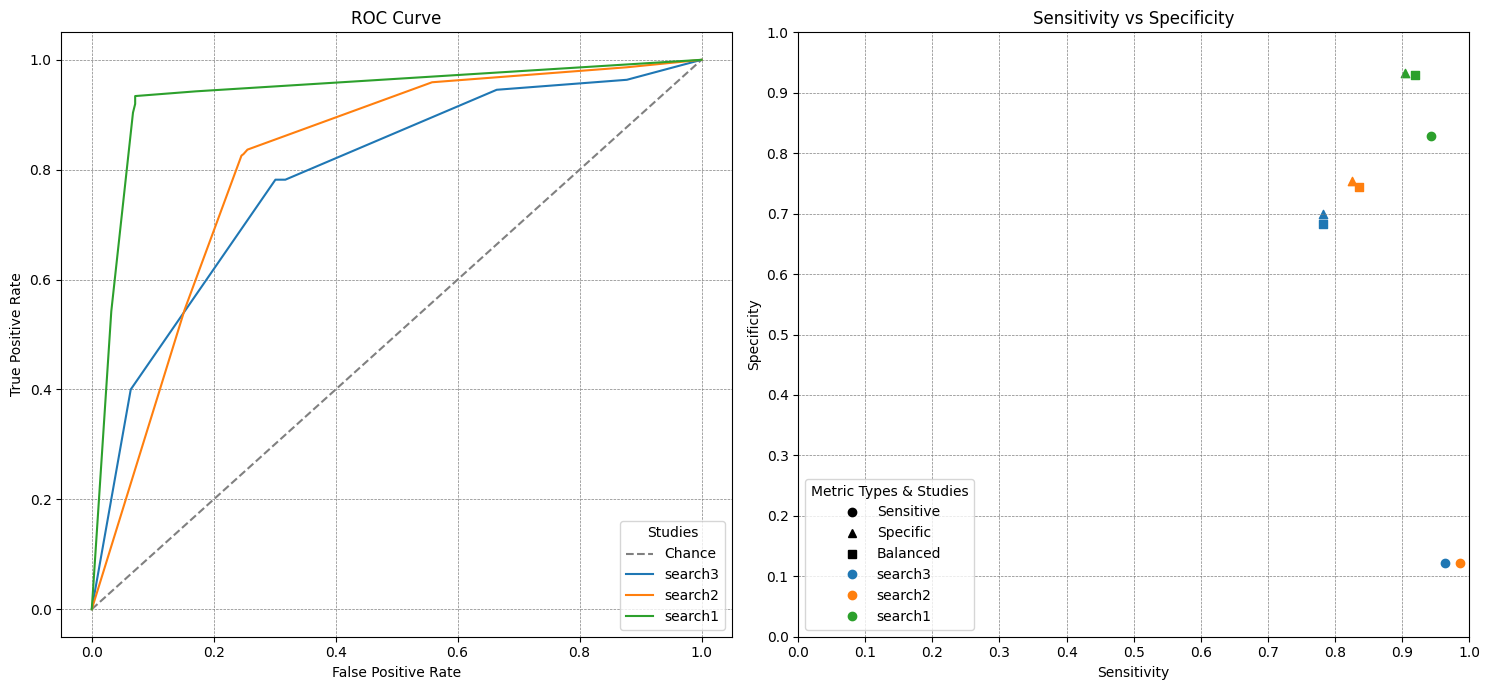

In [27]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1: ROC Curve
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
for dataset_name, (fpr, tpr, color) in roc_curves.items():
    axes[0].plot(fpr, tpr, label=dataset_name, color=color)
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(title="Studies", loc='lower right')  # Show studies' color codes in the ROC plot legend

# Add horizontal and vertical grid lines
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Plot 2: Sensitivity vs Specificity
for dataset_name, sens_sen, spec_sen, sens_spec, spec_spec, sens_bal, spec_bal, color in sensitivity_specificity_points:
    axes[1].scatter(sens_sen, spec_sen, marker='o', color=color)
    axes[1].scatter(sens_spec, spec_spec, marker='^', color=color)
    axes[1].scatter(sens_bal, spec_bal, marker='s', color=color)
axes[1].set_title("Sensitivity vs Specificity")
axes[1].set_xlabel("Sensitivity")
axes[1].set_ylabel("Specificity")
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_xticks([i * 0.1 for i in range(11)])
axes[1].set_yticks([i * 0.1 for i in range(11)])

# Add horizontal and vertical grid lines
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Create combined legend entries
legend_elements = [
    Line2D([], [], marker='o', color='black', linestyle='', label='Sensitive'),
    Line2D([], [], marker='^', color='black', linestyle='', label='Specific'),
    Line2D([], [], marker='s', color='black', linestyle='', label='Balanced'),
]

# Add dataset-specific colors to the legend
for dataset_name, *_ , color in sensitivity_specificity_points:
    legend_elements.append(
        Line2D([], [], marker='o', color=color, linestyle='', label=dataset_name)
    )

# Add the combined legend
axes[1].legend(
    handles=legend_elements,
    title="Metric Types & Studies",
    loc='lower left'
)

plt.tight_layout()
plt.show()
